# Read data

In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
# import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
X_train = np.load('./X_train.npy')
X_test = np.load('./X_test.npy')

y_train = pd.read_csv('./y_train.csv')
y_test = pd.read_csv('./sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


## Представление целевой переменной

### Kaggle-удобный вид

In [3]:
print(y_train.shape)
y_train

(32300, 2)


,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0
...,...,...
32295,322-95,4
32296,322-96,4
32297,322-97,4
32298,322-98,4


### Исходный вид

In [4]:
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)
y_train = y_train.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train = y_train.sort_index() # на всякий случай
y_train = y_train.values

print(y_train.shape)
y_train

(323, 100)


/tmp/ipykernel_12601/2431580455.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]])

### Переход от исходного вида к kaggle
Потенциально пригодится для формирования `y_test.csv`

In [5]:
df_y_train = []
for idx, arr in zip(y_train_index, y_train):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    df_y_train.append(series)
    
df_y_train = pd.concat(df_y_train)
df_y_train = df_y_train.reset_index()
df_y_train.columns = ["sample-timestep", "class"]
df_y_train

,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0
...,...,...
32295,322-95,4
32296,322-96,4
32297,322-97,4
32298,322-98,4


## Объяснение данных

### Train

In [6]:
X_train.shape, y_train.shape

((323, 40, 100), (323, 100))

`y_train.csv` содержит следующие классы: 
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

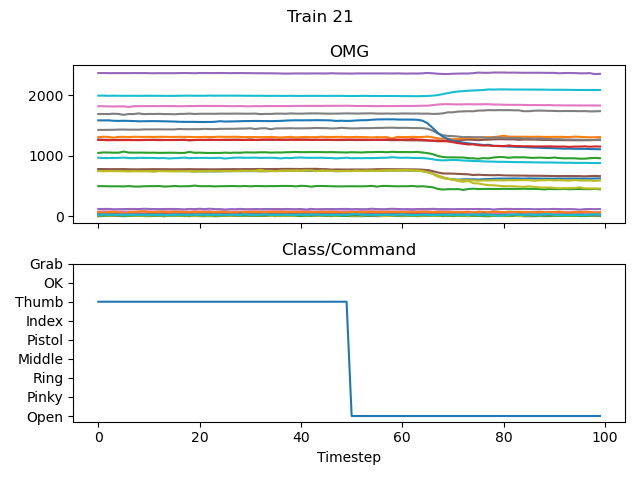

In [7]:
i = 21
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

### Test

Как видно из визуализации, для теста нет целевой переменной.

Это и есть задача хакатона - распознать, **какая команда была выполнена пользователем и в какое время**.

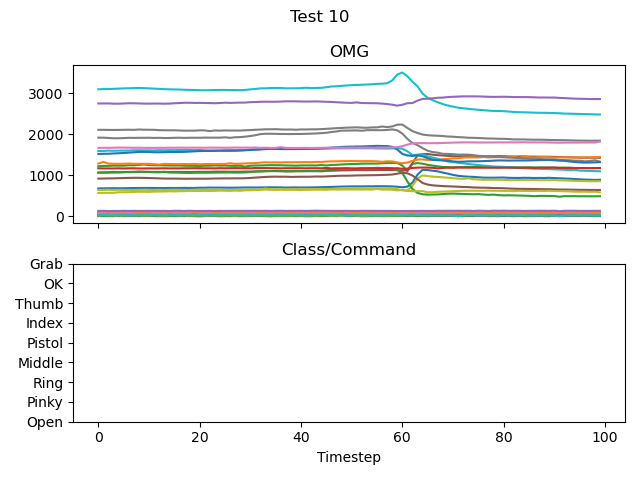

In [8]:
i = 10
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_test[i].T)
axx[0].set_title('OMG')

axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test {i}')

plt.tight_layout()

# NN Baseline

In [9]:
import tensorflow as tf

In [10]:
X_train_nn = X_train.swapaxes(1, 2)
X_test_nn = X_test.swapaxes(1, 2)
y_train_nn = tf.keras.utils.to_categorical(y_train)

print(X_train_nn.shape, y_train_nn.shape)
print(X_test_nn.shape)

(323, 100, 40) (323, 100, 9)
(54, 100, 40)


## Model architecture

In [11]:
input_channels = x = tf.keras.layers.Input(
    (100, 40),
)
x = tf.keras.layers.SimpleRNN(
    units=100,
    return_sequences=True,
    recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
    dropout=0.0,
    recurrent_dropout=0.0,
)(x)
x = tf.keras.layers.SimpleRNN(
    units=100,
    return_sequences=True,
    recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
    dropout=0.0,
    recurrent_dropout=0.0,
)(x)
output = tf.keras.layers.Dense(units=9, activation='sigmoid')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

2023-05-02 11:42:02.627288: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
    ],
    optimizer=tf.keras.optimizers.Adam(), # learning_rate=1e-2
)
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 40)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 100)          14100     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 100)          20100     
                                                                 
 dense (Dense)               (None, 100, 9)            909       
                                                                 
Total params: 35,109
Trainable params: 35,109
Non-trainable params: 0
_________________________________________________________________


In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Model train

In [14]:
history = model.fit(
    X_train_nn,
    y_train_nn, 
    epochs=200,
    verbose=1,
)

Epoch 1/200
11/11 [==============================] - 1s 17ms/step - loss: 17.1056 - accuracy: 0.5070
Epoch 2/200
11/11 [==============================] - 0s 17ms/step - loss: 15.0537 - accuracy: 0.5750
Epoch 3/200
11/11 [==============================] - 0s 19ms/step - loss: 13.2712 - accuracy: 0.6325
Epoch 4/200
11/11 [==============================] - 0s 20ms/step - loss: 11.6773 - accuracy: 0.6551
Epoch 5/200
11/11 [==============================] - 0s 17ms/step - loss: 10.2151 - accuracy: 0.6823
Epoch 6/200
11/11 [==============================] - 0s 17ms/step - loss: 8.9361 - accuracy: 0.7004
Epoch 7/200
11/11 [==============================] - 0s 18ms/step - loss: 7.7890 - accuracy: 0.7189
Epoch 8/200
11/11 [==============================] - 0s 18ms/step - loss: 6.7845 - accuracy: 0.7222
Epoch 9/200
11/11 [==============================] - 0s 17ms/step - loss: 5.8765 - accuracy: 0.7221
Epoch 10/200
11/11 [==============================] - 0s 18ms/step - loss: 5.1143 - accuracy: 0

## Visualisation

In [15]:
y_pred_train_nn = model.predict(X_train_nn)
y_pred_train_nn.shape

(323, 100, 9)

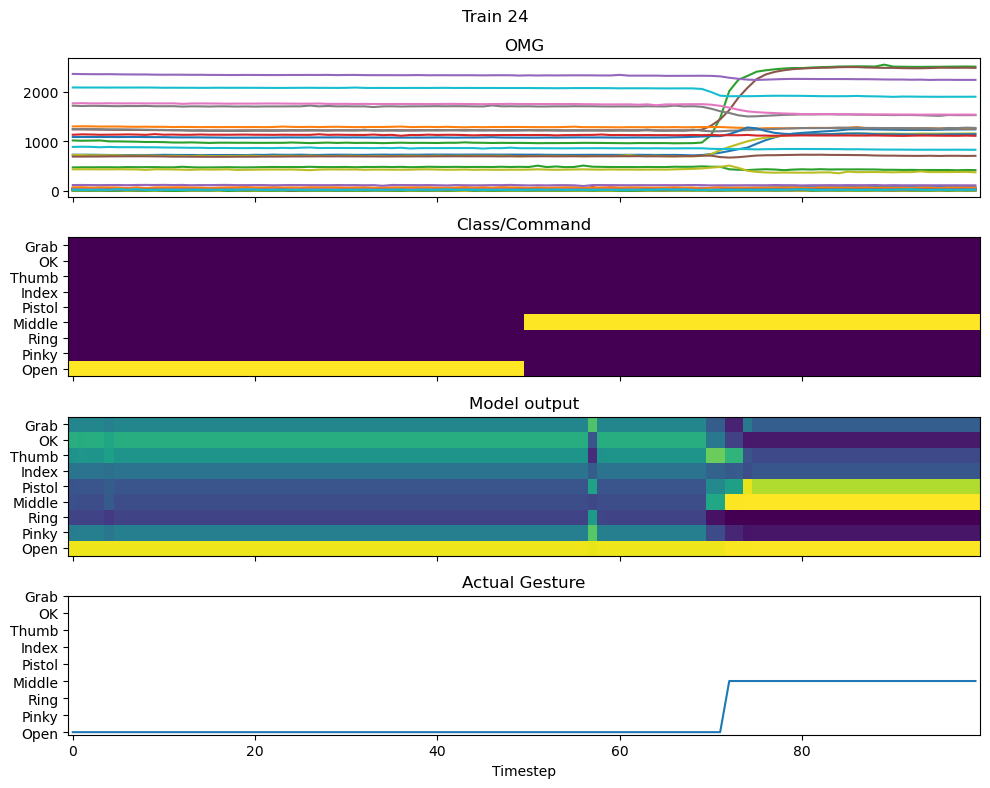

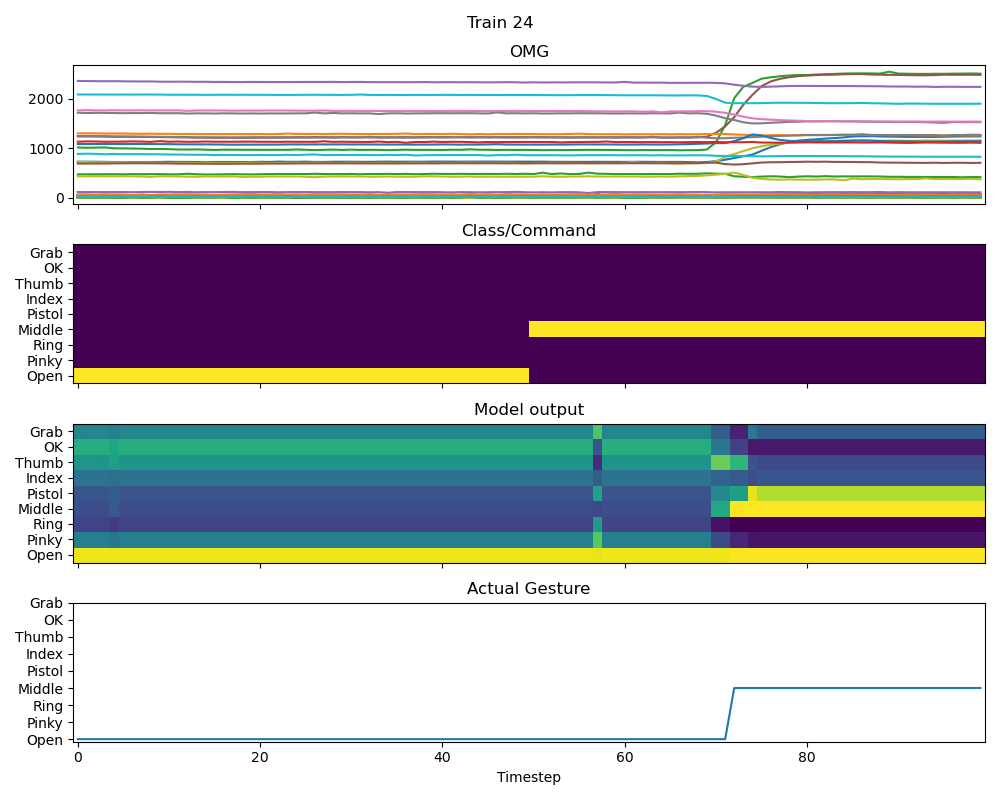

In [16]:
i = 24

fig, axx = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].imshow(y_train_nn[i].T, origin="lower")
axx[1].set_aspect('auto')
axx[1].set_title('Class/Command')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

axx[2].imshow(y_pred_train_nn[i].T, origin="lower") # , vmin=-0.5, vmax=0.5
axx[2].set_aspect('auto')
axx[2].set_title('Model output')
axx[2].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

axx[3].plot(y_pred_train_nn[i].argmax(axis=-1))
axx[3].set_aspect('auto')
axx[3].set_title('Actual Gesture')
axx[3].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)
axx[3].set_xlabel('Timestep')

plt.suptitle(f'Train {i}')

plt.tight_layout()

plt.gcf()

### Интерпретация графиков

График 1 - это данные зафиксированные оптомиографическими датчиками. График 2 подача команды на совершение жеста для пилота. Как можно видеть есть некоторый временной лаг, объясняемый временем реакции.

График 3 - это предсказания модели. График 4 - это фактическое движение, на тестовых данных именно оно будет использоваться для скоринга.

## Model predict

In [17]:
y_pred_nn = model.predict(X_test_nn).argmax(axis=-1)

print(y_pred_nn.shape)
y_pred_nn

(54, 100)


array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 5, 5],
       [5, 5, 5, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]])

In [18]:
y_pred = np.concatenate([arr for arr in y_pred_nn])

print(y_pred.shape)
y_pred

(5400,)


array([4, 4, 4, ..., 4, 4, 4])

In [19]:
y_test['class'] = y_pred
y_test.to_csv('./y_test_2rnn_sigmoid_predicted.csv', index=False)
y_test

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
...,...,...
5395,376-95,4
5396,376-96,4
5397,376-97,4
5398,376-98,4


In [116]:
y_test['class'].value_counts()

0    3608
5     524
2     402
8     278
3     271
1     203
6     114
Name: class, dtype: int64